In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement

In [2]:
data = np.load('../../data/quark_gluon_dataset_1/quark_gluon_125_40000_1.npz', allow_pickle=True)

In [3]:
zeros = (data["y"] == 0)
ones = (data["y"] == 1)
print(sum(zeros), sum(ones))

9980 10020


In [4]:
data0 = data["X_jets"][zeros]
data1 = data["X_jets"][ones]
del data

In [5]:
def mean_data(data, channels):
    for i in range(channels):
        mean = np.mean(data[:, :,:, i], axis=0).mean()
    return mean

In [6]:
def display_data(data, label, thresh=0):
    fig = plt.figure(figsize=(12,12))
    r = 1
    c = 3
    for i in range(3):
        fig.add_subplot(r,c,i+1)
        if thresh:
            m = np.mean(data[:, :,:, i], axis=0).mean()
            plt.imshow(np.mean(data[:, :,:, i], axis=0) >= m) # meaning
        else:
            plt.imshow(np.log(np.mean(data[:, :,:, i], axis=0))) #meaning

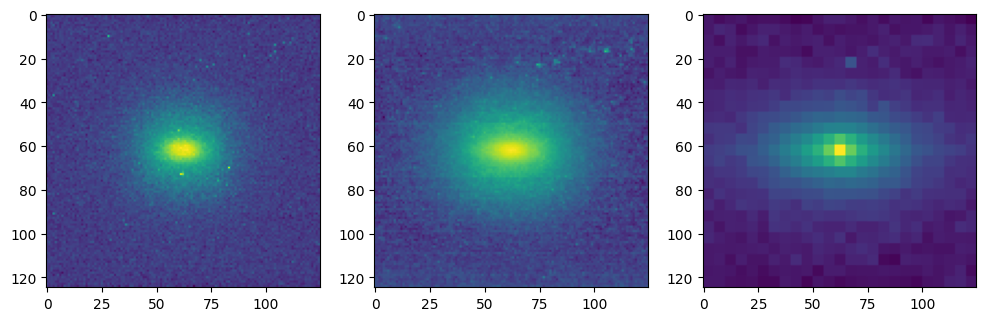

In [7]:
display_data(data0,"Gluon")

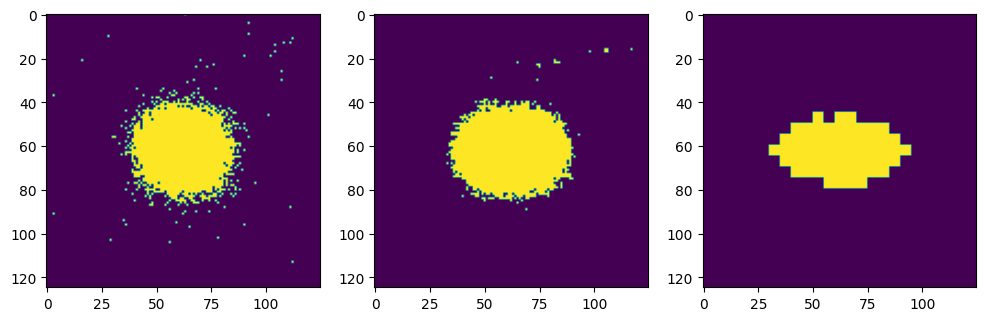

In [8]:
display_data(data0,"Gluon",thresh=1)

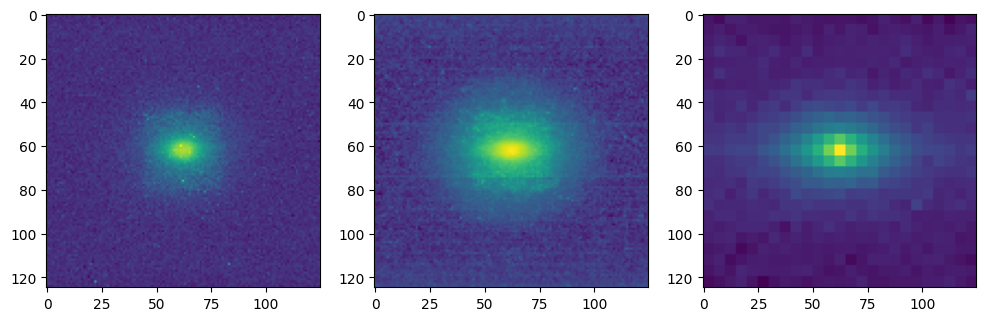

In [9]:
display_data(data1,"Quark")

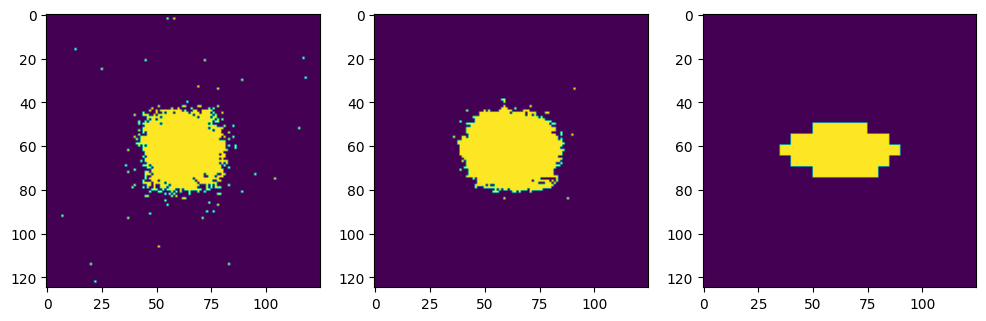

In [10]:
display_data(data1,"Quark",thresh=1)

In [11]:
zeros = np.array([0]*len(data0))
ones = np.array([1]*len(data1))

x = np.concatenate((data0,data1), axis =0)
y = np.concatenate((zeros,ones), axis= 0)

print(x.shape, y.shape)

(20000, 125, 125, 3) (20000,)


In [12]:
# del data0, data1

In [13]:
x, y = shuffle(x,y)

In [14]:
import tensorflow as tf

def normalize_image_channel(image_channel):
    """
    Apply logarithmic transformation and normalization to a single image channel.
    
    Parameters:
    - image_channel: A 2D numpy array representing a single channel of the image.
    
    Returns:
    - normalized_image: The normalized image channel.
    """
    normalized_image = np.log(np.abs(image_channel) + 1e-6)
    normalized_image = (normalized_image - normalized_image.min()) / (normalized_image.max() - normalized_image.min() + 1e-6)
    return normalized_image

def normalize_combined_image(image, num_channels):
    """
    Apply logarithmic transformation and normalization to the combined multi-channel image.
    
    Parameters:
    - image: A 3D numpy array representing the multi-channel image.
    - num_channels: The number of channels in the image (2 or 3).
    
    Returns:
    - combined_image: The normalized combined multi-channel image.
    """
    combined_image = np.log(np.abs(image) + 1e-6)
    combined_image = np.stack([(channel - channel.min()) / (channel.max() - channel.min() + 1e-6) 
                               for channel in combined_image.transpose(2, 0, 1)]).transpose(1, 2, 0)
    
    # Handle two-channel images by adding a zero channel to make it compatible with RGB display
    if num_channels == 2:
        zeros_channel = np.zeros_like(combined_image[:, :, 0])
        combined_image = np.stack([combined_image[:, :, 0], combined_image[:, :, 1], zeros_channel], axis=-1)
    
    return combined_image

def color_jitter(image, s=1.0):
    """
    Apply color jittering to an image.
    
    Parameters:
    - image: A tensor with value range [0, 1] representing the image.
    - s: Strength of the color distortion.
    
    Returns:
    - jittered_image: The color jittered image.
    """
    image = tf.image.random_brightness(image, max_delta=0.8 * s)
    image = tf.image.random_contrast(image, lower=1 - 0.8 * s, upper=1 + 0.8 * s)
    image = tf.image.random_saturation(image, lower=1 - 0.8 * s, upper=1 + 0.8 * s)
    image = tf.image.random_hue(image, max_delta=0.2 * s)
    image = tf.clip_by_value(image, 0, 1)
    return image

def color_distortion(image, s=1.0):
    """
    Apply color distortion to an image, including jittering and color dropping.
    
    Parameters:
    - image: A tensor with value range [0, 1] representing the image.
    - s: Strength of the color distortion.
    
    Returns:
    - distorted_image: The color distorted image.
    """
    def random_apply(func, x, p):
        return tf.cond(tf.less(tf.random.uniform([], 0, 1), p), lambda: func(x), lambda: x)

    image = random_apply(lambda x: color_jitter(x, s=s), image, p=0.8)
    image = random_apply(lambda x: tf.tile(tf.image.rgb_to_grayscale(x), [1, 1, 3]), image, p=0.2)
    return image

def gaussian_blur(image, kernel_size=5, sigma=1.0):
    """
    Apply Gaussian blur to a point cloud image.
    
    Parameters:
    - image: A 2D or 3D numpy array representing the image.
    - kernel_size: Size of the Gaussian kernel.
    - sigma: Standard deviation of the Gaussian kernel.
    
    Returns:
    - blurred_image: The Gaussian blurred image.
    """
    from scipy.ndimage import gaussian_filter
    
    if image.ndim == 2:
        blurred_image = gaussian_filter(image, sigma=sigma)
    elif image.ndim == 3:
        blurred_image = np.stack([gaussian_filter(image[:, :, i], sigma=sigma) for i in range(image.shape[2])], axis=-1)
    else:
        raise ValueError("Image must be 2D or 3D numpy array.")
    
    return blurred_image

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
import tensorflow as tf

# Assume other functions (normalize_image_channel, normalize_combined_image, color_jitter, color_distortion, gaussian_blur) are already defined above

def plot_image_da(images, num_channels=3, normalize=True, normalize_combined=True, apply_jitter=True, apply_blur=False,
               jitter_strength=0.005, blur_sigma=0.2, filename=None, y_label=None, x_label=None, distribution=None):
    """
    Plots images with separate channels and possibly a combined image for multi-channel inputs. Adds outlines to text.
    Optionally applies color jittering and Gaussian blur to the images.
    
    Parameters:
    - images: List of images to be plotted.
    - num_channels: Number of channels in the images (1 for grayscale, 2 for two-channel, 3 for RGB).
    - normalize: Whether to apply log transformation and normalization to the channels.
    - normalize_combined: Whether to apply log transformation and normalization to the combined multi-channel image.
    - apply_jitter: Whether to apply color jittering to the images.
    - apply_blur: Whether to apply Gaussian blur to the images.
    - jitter_strength: Strength of the color jittering effect.
    - blur_sigma: Standard deviation for the Gaussian blur.
    - filename: If provided, saves the plot to this filename.
    - y_label: Y-axis label.
    - x_label: X-axis label.
    - distribution: Tuple specifying the layout of images. 
                    e.g., (2, 3) will layout images in 2 rows and 3 columns.
    
    """
    
    # Define colormaps based on number of channels
    if num_channels == 1:
        cmaps = ['gray']
    else:
        cmaps = ['Reds', 'Greens', 'Blues']

    plt.rcParams.update({'font.size': 16})

    # If grayscale and images are 2D, expand dimensions
    if num_channels == 1 and len(images[0].shape) == 2:
        images = [np.expand_dims(image, axis=-1) for image in images]

    # Determine rows and columns based on distribution and channels
    if distribution:
        rows, cols = distribution
        total_cols = cols * (num_channels + int(num_channels > 1))
    else:
        rows = len(images)
        total_cols = num_channels + int(num_channels > 1)

    fig, axs = plt.subplots(rows, total_cols, figsize=(total_cols * 2.8, 2.8 * rows),
                            sharey=True, sharex=True)
    
    # Handle single row or column case
    if rows == 1:
        axs = np.expand_dims(axs, axis=0)
    if total_cols == 1:
        axs = np.expand_dims(axs, axis=-1)

    # Define path effects to outline text
    pe = [withStroke(linewidth=5, foreground="w")]

    image_counter = 0
    for j in range(rows):
        for k in range(0, total_cols, num_channels + int(num_channels > 1)):
            if image_counter < len(images):
                image = images[image_counter]

                # Apply color jittering if enabled
                if apply_jitter:
                    image = color_jitter(tf.convert_to_tensor(image, dtype=tf.float32), s=jitter_strength).numpy()

                # Apply Gaussian blur if enabled
                if apply_blur:
                    image = gaussian_blur(image, sigma=blur_sigma)

                for i in range(num_channels):
                    im = image[:, :, i]
                    if normalize:
                        im = normalize_image_channel(im)
                    axs[j, k+i].imshow(im, cmap=cmaps[i])
                    axs[j, k+i].grid(False)
                    # Apply path effects to tick labels
                    for label in axs[j, k+i].get_xticklabels() + axs[j, k+i].get_yticklabels():
                        label.set_path_effects(pe)

                # Display combined multi-channel image
                if num_channels > 1:
                    combined_image = image.copy()
                    if normalize_combined:
                        combined_image = normalize_combined_image(combined_image, num_channels)
                    axs[j, k+num_channels].imshow(combined_image)
                    axs[j, k+num_channels].grid(False)
                    # Apply path effects to tick labels
                    for label in axs[j, k+num_channels].get_xticklabels() + axs[j, k+num_channels].get_yticklabels():
                        label.set_path_effects(pe)

                # Set labels if provided
                if y_label is not None and k == 0:
                    ylabel_obj = axs[j, k].set_ylabel(y_label)
                    ylabel_obj.set_path_effects(pe)
                if x_label is not None and j == rows - 1:
                    for col in range(total_cols):
                        xlabel_obj = axs[j, col].set_xlabel(x_label)
                        xlabel_obj.set_path_effects(pe)

                image_counter += 1

    plt.tight_layout()
    plt.gca().patch.set_facecolor('none')
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', transparent=True)  # Save with transparent background
    plt.show()


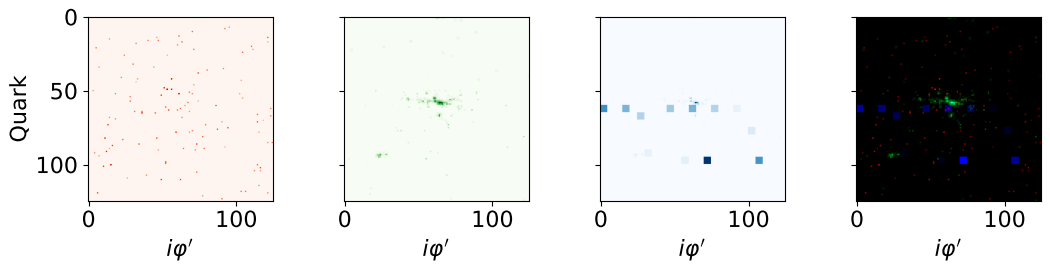

In [16]:
plot_image_da(data1[:1], filename='qg_ones.png', y_label=r"Quark", x_label=r"$i\varphi'$")

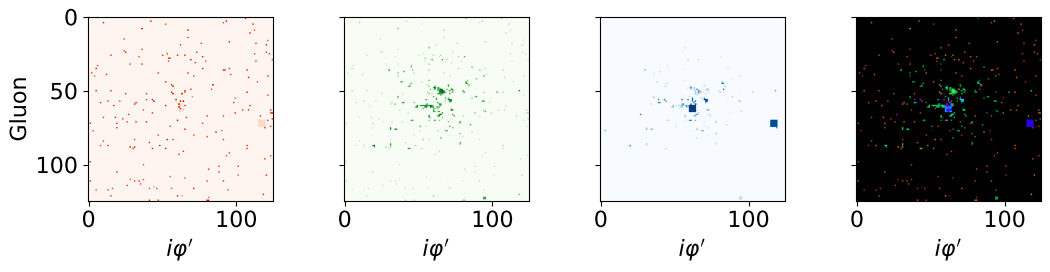

In [17]:
plot_image_da(data0[:1], filename='qg_ones.png', y_label=r"Gluon", x_label=r"$i\varphi'$")

In [18]:
import numpy as np
import tensorflow as tf
from scipy.ndimage import gaussian_filter

def transform_images(images, apply_jitter=True, jitter_strength=0.005, 
                     apply_blur=False, blur_sigma=1.0, normalize=True, normalize_combined=True):
    """
    Transform images using color jittering, Gaussian blur, and normalization.
    Saves the combined image as the 4th channel.
    
    Parameters:
    - images: Numpy array of images to be transformed.
    - apply_jitter: Whether to apply color jittering to the images.
    - jitter_strength: Strength of the color jittering effect.
    - apply_blur: Whether to apply Gaussian blur to the images.
    - blur_sigma: Standard deviation for the Gaussian blur.
    - normalize: Whether to apply log transformation and normalization to the channels.
    - normalize_combined: Whether to apply log transformation and normalization to the combined multi-channel image.
    
    Returns:
    - transformed_images: Numpy array of transformed images with an additional combined 4th channel.
    """

    # Convert images to TensorFlow tensor for batch processing if necessary
    if apply_jitter or apply_blur:
        images = tf.convert_to_tensor(images, dtype=tf.float32)
    
    # Apply color jittering to the entire batch if enabled
    if apply_jitter:
        images = tf.image.random_brightness(images, max_delta=0.8 * jitter_strength)
        images = tf.image.random_contrast(images, lower=1 - 0.8 * jitter_strength, upper=1 + 0.8 * jitter_strength)
        images = tf.image.random_saturation(images, lower=1 - 0.8 * jitter_strength, upper=1 + 0.8 * jitter_strength)
        images = tf.image.random_hue(images, max_delta=0.2 * jitter_strength)
        images = tf.clip_by_value(images, 0, 1)
    
    # Convert back to numpy array for Gaussian blur and normalization
    if apply_blur or normalize or normalize_combined:
        images = images.numpy()

    # Apply Gaussian blur to the entire batch if enabled
    if apply_blur:
        def apply_gaussian_blur(image_batch):
            return np.stack([gaussian_filter(image, sigma=blur_sigma) for image in image_batch])
        
        images = apply_gaussian_blur(images)

    # Normalize each channel if enabled
    if normalize:
        images = np.log(np.abs(images) + 1e-6)
        images = (images - images.min(axis=(1, 2), keepdims=True)) / (images.max(axis=(1, 2), keepdims=True) - images.min(axis=(1, 2), keepdims=True) + 1e-6)
    
    # Normalize combined image if enabled and multi-channel
    if normalize_combined and images.shape[-1] > 1:
        combined_images = np.mean(images, axis=-1, keepdims=True)
        combined_images = np.log(np.abs(combined_images) + 1e-6)
        combined_images = (combined_images - combined_images.min(axis=(1, 2), keepdims=True)) / (
                          combined_images.max(axis=(1, 2), keepdims=True) - combined_images.min(axis=(1, 2), keepdims=True) + 1e-6)
        
        # Add the combined image as the 4th channel
        images = np.concatenate([images, combined_images], axis=-1)
    
    return images

In [19]:
del data0, data1

In [20]:
x_transformed = transform_images(x, apply_jitter=True, jitter_strength=0.005, apply_blur=False, blur_sigma=0.002, normalize=True, normalize_combined=True)

In [21]:
def plot_four_channels(image, channels):
    """
    Plot the four channels of an image.

    Parameters:
    - image: A 3D numpy array representing the image (height, width, 4 channels).
    """
    
    fig, axs = plt.subplots(1, channels, figsize=(16, 4))
    cmaps = ['Reds', 'Greens', 'Blues', 'Purples']
    
    for i in range(channels):
        axs[i].imshow(image[:, :, i])
        axs[i].set_title(f'Channel {i+1}')
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

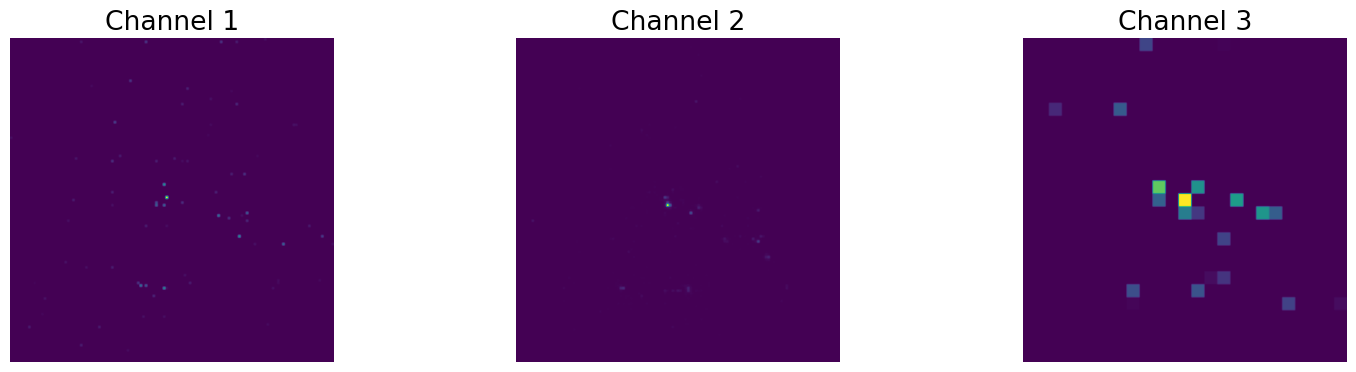

In [22]:
plot_four_channels(x[0],3)

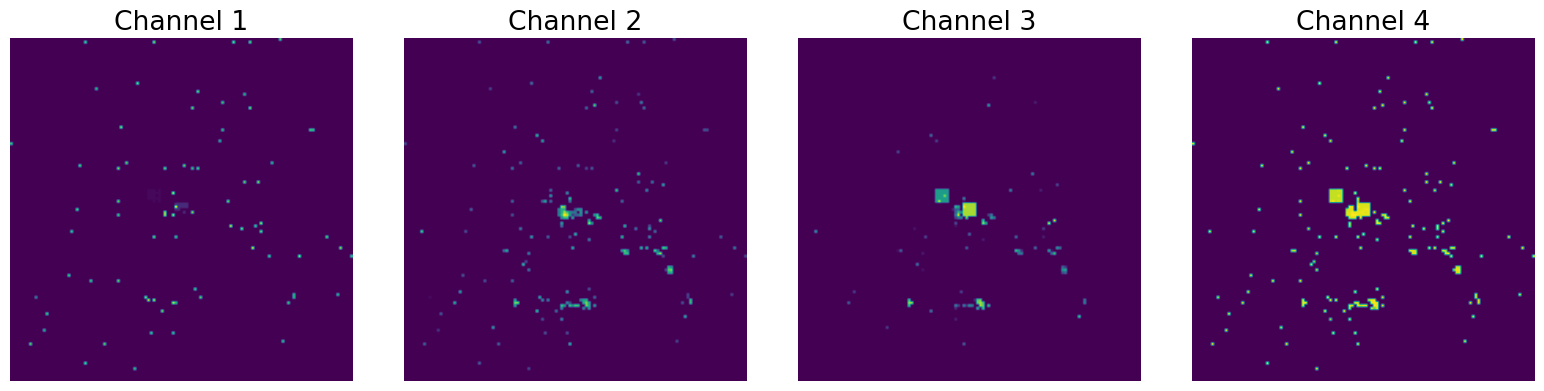

In [23]:
plot_four_channels(x_transformed[0], 4)

In [24]:
d0_x = x_transformed[y==0].mean(axis=0)

In [25]:
d0_x.shape

(125, 125, 4)

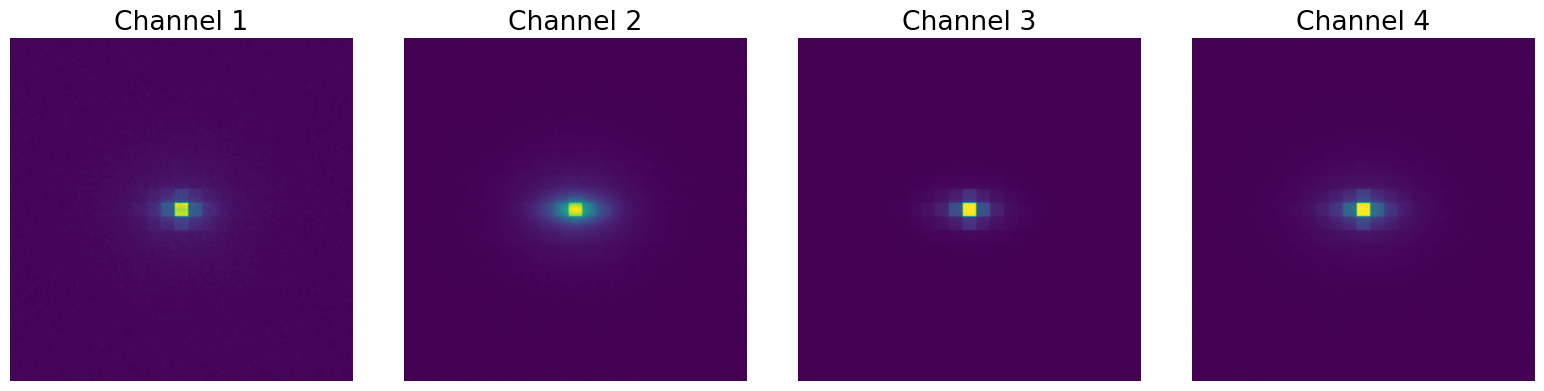

In [26]:
plot_four_channels(d0_x, 4)

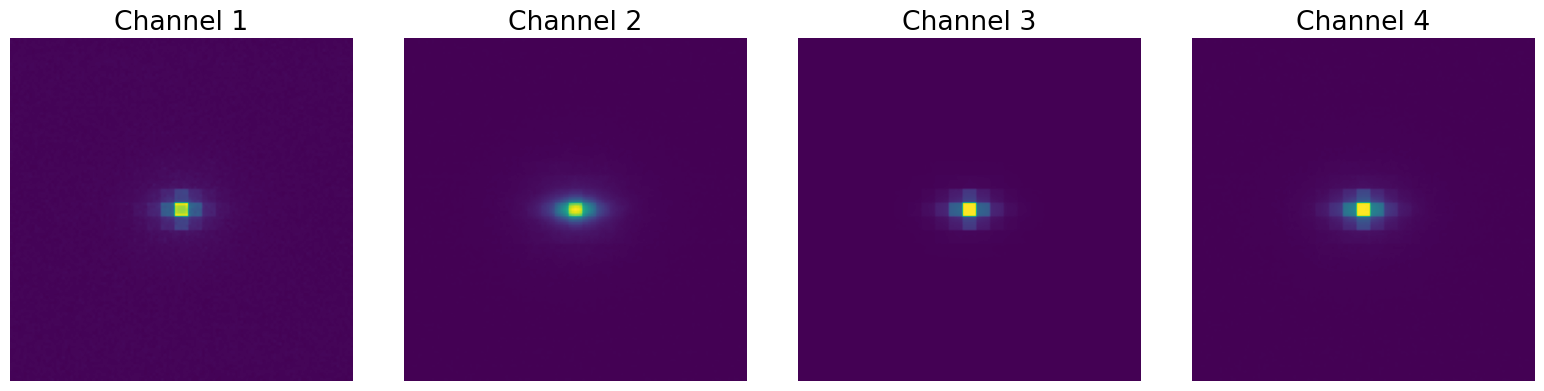

In [27]:
d1_x = x_transformed[y==1].mean(axis=0)
plot_four_channels(d1_x, 4)

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x_transformed,y, test_size = 0.20, random_state=42, stratify=y)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(16000, 125, 125, 4) (16000,)
(4000, 125, 125, 4) (4000,)


In [29]:
# data["x_train"].shape

In [30]:
# x_train_0 = data["x_train"][data["y_train"] == 0]
# x_train_1 = data["x_train"][data["y_train"] == 1]

In [31]:
# x_train_0 = x_train_0[:4000]
# x_train_0.shape

In [32]:
# x_train_1 = x_train_1[:4000]
# x_train_1.shape

In [33]:
# y_train_0 = data["y_train"][data["y_train"] == 0]
# y_train_1 = data["y_train"][data["y_train"] == 1]
# y_train_0 = y_train_0[:4000]
# y_train_1 = y_train_1[:4000]
# y_train_1.shape

In [34]:
# # Merge x_train and y_train
# x_train_merged = np.concatenate((x_train_0, x_train_1), axis=0)
# y_train_merged = np.concatenate((y_train_0, y_train_1), axis=0)
    
# # Shuffle the data
# shuffled_indices = np.random.permutation(len(x_train_merged))
# x_train_shuffled = x_train_merged[shuffled_indices]
# y_train_shuffled = y_train_merged[shuffled_indices]

# x_train_shuffled.shape
# y_train_shuffled.shape

In [35]:
# x_train_shuffled.shape

In [36]:
# # Create pairs of images and labels and saving npz of channel 4
# def create_pairs(images, labels):
#     pairs = []
#     pair_labels = []

#     num_classes = len(np.unique(labels)) # 2
#     digit_indices = [np.where(labels == i)[0] for i in range(num_classes)]
#     # print(digit_indices)

#     for idx1 in range(len(images)):
#         x1, label1 = images[idx1], labels[idx1]
#         idx2 = np.random.choice(digit_indices[int(label1)])
#         x2 = images[idx2]

#         # if x1==x2, label set to 1
#         pairs.append([x1, x2])
#         pair_labels.append(1)

#         # if x1!=x2, label set to 0
#         label2 = (label1 + np.random.randint(1, num_classes)) % num_classes
#         idx2 = np.random.choice(digit_indices[int(label2)])
#         x2 = images[idx2]
#         pairs.append([x1, x2])
#         pair_labels.append(0)

#     return np.array(pairs), np.array(pair_labels)

In [37]:
import cv2
import numpy as np

def augment_image(image):
    # Apply a series of augmentations to the image (125, 125, 4)
    
    # Ensure the image has 4 channels
    assert image.shape[2] == 4, "Input image must have 4 channels"

    # 1. Random rotation between -30 and 30 degrees (apply to all channels)
    angle = np.random.uniform(-30, 30)
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    rotated = np.stack([cv2.warpAffine(image[:, :, i], M, (w, h)) for i in range(4)], axis=-1)

    # # 2. Add Gaussian noise (apply to all channels)
    # noise = np.random.normal(0, 25, image.shape).astype(np.uint8)  # Adjust std (25) for noise intensity
    # noisy_image = np.clip(rotated + noise, 0, 255).astype(np.uint8)  # Apply noise to all channels

    # # 3. Random flip (apply to all channels)
    # flip_code = np.random.choice([-1, 0, 1])  # -1: both, 0: vertical, 1: horizontal
    # flipped = np.stack([cv2.flip(noisy_image[:, :, i], flip_code) for i in range(4)], axis=-1)

    # 4. Random zoom (apply to all channels)
    # zoom_factor = np.random.uniform(0.8, 1.2)  # Zoom between 80% and 120%
    # new_size = (int(w * zoom_factor), int(h * zoom_factor))
    # zoomed = np.stack([cv2.resize(rotated[:, :, i], new_size) for i in range(4)], axis=-1)

    # # Crop to original size after zoom (apply to all channels)
    # crop_x = max(0, (zoomed.shape[1] - w) // 2)
    # crop_y = max(0, (zoomed.shape[0] - h) // 2)
    # zoomed_cropped = zoomed[crop_y:crop_y + h, crop_x:crop_x + w, :]

    return rotated


In [38]:
def create_pairs(images, labels):
    pairs = []
    pair_labels = []

    # Get indices for class 0 and class 1
    class_0_indices = np.where(labels == 0)[0]
    class_1_indices = np.where(labels == 1)[0]

    # Create positive pairs (class 0 image and its augment)
    for idx in class_0_indices:
        x1 = images[idx]
        x2 = augment_image(x1)  # Apply complex augmentation to create a positive pair
        pairs.append([x1, x2])
        pair_labels.append(1)  # Label 1 for positive pair

    # Create negative pairs (class 0 image with class 1 image)
    for idx in class_1_indices:
        x1 = images[idx]
        x2 = augment_image(x1)  # Apply complex augmentation to the class 1 image
        pairs.append([x1, x2])
        pair_labels.append(0)  # Label 0 for negative pair

    return np.array(pairs), np.array(pair_labels)


In [39]:
del x

In [40]:
# preprocessed_4th_channel_images
# x_train = add_fourth_channel(x_train)
# x_test = add_fourth_channel(x_test)
pairs, labels = create_pairs(x_transformed, y)
# pairs, labels = create_pairs(x, y)
# pairs_test, labels_test = create_pairs(preprocess_all_images(x_test), y_test)

print(f"After pair creation: pairs: {pairs.shape}, labels: {labels.shape}")

After pair creation: pairs: (20000, 2, 125, 125, 4), labels: (20000,)


In [42]:
del x_transformed,y

In [43]:
pairs, label = shuffle(pairs, labels)

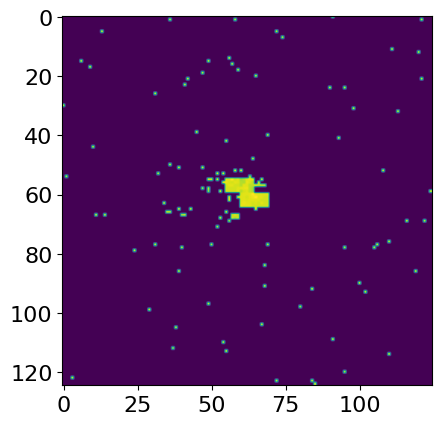

In [44]:
plt.imshow(pairs[67,0,:,:,3])

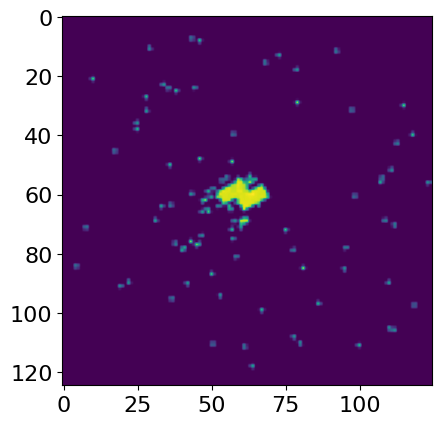

In [45]:
plt.imshow(pairs[67,1,:,:,3])

In [46]:
np.savez_compressed('../../data/quark_gluon_dataset_1/qg_20000_views_c4.npz', **{
    'pairs': pairs,
    'labels':labels
})